## Demo notebook for accessing NEXRAD data on Azure

This notebook provides an example of accessing NEXRAD data from blob storage on Azure, then plotting it using the fantastic [Py-ART](https://arm-doe.github.io/pyart/) library for working with radar data.

We will demonstrate how to access and plot a scan given a known scan filename, as well as how to access scans by lat/lon/time.

NEXRAD data are stored in the East US data center, so this notebook will run most efficiently on Azure compute located in East US.  We recommend that substantial computation depending on NEXRAD data also be situated in East US: you don't want to download hundreds of terabytes to your laptop!  If you are using NEXRAD data for environmental science applications (including weather forecasting), consider applying for an [AI for Earth grant](http://aka.ms/aiforearth) to support your compute requirements.

### Imports and environment

In [1]:
# Standard-ish imports
import matplotlib.pyplot as plt
import warnings
import urllib.request
import tempfile
import os
import requests
import shutil

# Less standard, but still pip- or conda-installable
import sqlite3
import geopy.distance

# pip install progressbar2, not progressbar
import progressbar

# Suppress some warnings generated within pyart
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=UserWarning)
import pyart

%matplotlib inline

# URL of our index file
index_db_url = 'https://nexradsa.blob.core.windows.net/nexrad-index/NEXRAD_sqllite.db'

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(),'nexrad')
os.makedirs(temp_dir,exist_ok=True)

# Local copy of the index file
index_db_file_name = os.path.join(temp_dir,'NEXRAD_sqllite.db')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Functions

In [2]:
class DownloadProgressBar():
    """
    https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve
    """
    
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(max_value=total_size)
            self.pbar.start()
            
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()
            

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('.', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {}'.format(os.path.basename(url)),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename
    

def download_index_db():
    """
    We have created an index (as SQLite db file) that tracks all records added to our NEXRAD 
    archive; this function will download that index (~40GB) to a local temporary file, if it
    hasn't already been downloaded.  This is a much more sensible thing to do inside the East
    US data center than outside!
    """
    
    if os.path.isfile(index_db_file_name):
        print('Index file {} exists, bypassing download'.format(os.path.basename(index_db_file_name)))
        return        
    else:
        download_url(index_db_url, index_db_file_name, DownloadProgressBar())


def distance(lat1, lon1, lat2, lon2):
    """
    Compute the distance in meters between two lat/lon coordinate pairs
    """
    
    return geopy.distance.distance((lat1, lon1), (lat2, lon2)).m


def get_closest_coordinate(coordinate_list, lat, lon):
    """
    Find the closest point in a list of lat/lon pairs, used here to find the closest radar
    station to a given lat/lon pair.
    """
    
    return min(coordinate_list, key=lambda p: distance(lat, lon, p['lat'], p['lon']))


def get_records(sql):
    """
    Execute a SQL query on the index database; returns matching rows.
    """
    
    download_index_db()
    conn = sqlite3.connect(index_db_file_name)
    
    with conn:
        cursor = conn.execute(sql)
        rows = cursor.fetchall()
        return rows
    

def get_scans_for_nearest_station(lat, lon, start_date, end_date):
    """
    Find all records in a given date range from the station closest to the 
    specified lat/lon pair.
    """
    
    # ICAO is the for-letter code for the station, e.g. "KTLX"
    sql = 'SELECT lat, lon, ICAO, name FROM station_latlon'
    records = get_records(sql)

    coordinate_list = []
    for row in records:
        coordinate_list.append({'lat': row[0], 'lon': row[1],
                                'icao': row[2], 'name': row[3]})
    
    # Find the coordinates of the station closest to the given latitude and longitude
    print('Searching for the nearest station to {},{}'.format(lat,lon))
    closest_coordinate  = get_closest_coordinate(coordinate_list, lat, lon)
    
    print('Nearest station ({}, {}) found at {},{}'.format(
        closest_coordinate['icao'], closest_coordinate['name'],
        closest_coordinate['lat'], closest_coordinate['lon']))
    
    # Get scans for the nearest station for a given date range
    sql = '''SELECT * FROM station_index a INNER JOIN \
            station_latlon b ON a.name = b.ICAO \
            and (b.lat = {} and b.lon = {} and \
            date(a.date_time) >= '{}' \
            and date(a.date_time) <= '{}')'''.format(closest_coordinate['lat'], 
                                                     closest_coordinate['lon'], 
                                                     start_date, end_date)

    files_info = get_records(sql)
    return files_info


def display_scan(filename):
    """
    Use PyART to plot a NEXRAD scan stored in [filename].
    """
    
    radar = pyart.io.read_nexrad_archive(filename)
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure()
    ax = fig.add_subplot()
    display.plot('reflectivity', 0, title='Reflectivity', ax=ax)
    plt.show()

### Access and plot a scan by constructing a filename

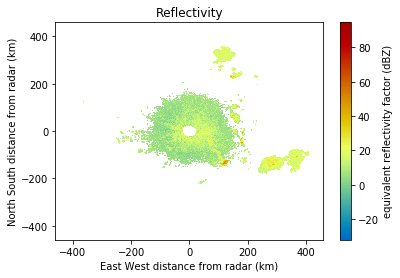

In [6]:
year = '2020'; month = '09'; day = '02'; station = 'KMXX'; time = '011116';
filename = station + year + month + day + '_' + time + '_V06.ar2v'
url = 'https://nexradsa.blob.core.windows.net/nexrad-l2/' + year + '/' + month + '/' + day + \
   '/' + station + '/' + filename
filename = download_url(url)
display_scan(filename)

### Access and plot a scan by querying location and time

Index file NEXRAD_sqllite.db exists, bypassing download
Searching for the nearest station to 47.674,-122.1215
Nearest station (KATX, SEATTLE) found at 48.19472,-122.49444
Index file NEXRAD_sqllite.db exists, bypassing download
Found 2909 files near station: KATX
Found 2575 non-MDM files near station: KATX


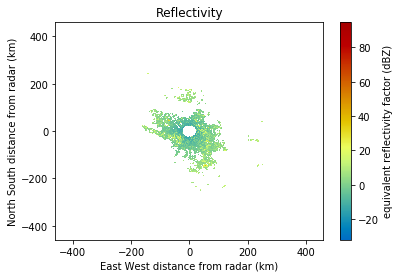

In [10]:
start_date = '2020-08-02'; end_date = '2020-08-15'
    
# Coordinates near Redmond, WA
lat = 47.6740; lon = -122.1215

# Find all files from the nearest station in the given date range
#
# The first time you call this function, it will download the ~40GB index file.
scan_files = get_scans_for_nearest_station(lat, lon, start_date, end_date)

# MDM files are not actually scans
scan_files = [s for s in scan_files if 'MDM' not in s[6]]

print('Found {} files near station: {}'.format(len(scan_files),scan_files[0][1]))

# Download the first scan
year = str(scan_files[0][2]); month = str(scan_files[0][3]); day = str(scan_files[0][4]); 
station = scan_files[0][1]; filename = scan_files[0][6]
url = 'https://nexradsa.blob.core.windows.net/nexrad-l2/' + year.zfill(2) + '/' + \
month.zfill(2) + '/' + day.zfill(2) + \
   '/' + station + '/' + filename
filename = download_url(url)
display_scan(filename)

### Clean up temporary files (including the index)

In [ ]:
shutil.rmtree(temp_dir)